In [174]:
import numpy as np
import scipy
from qutip import *
from numba import jit, njit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot
import plotly.graph_objs as go

In [175]:
def spin_operators(N):
    arr_sx = []
    arr_sy = []
    arr_sz = []
    arr_s_ = []
    for n in range(N):
        if n == 0:
            sx_n = 0.5*sigmax() 
            sy_n = 0.5*sigmay() 
            sz_n = 0.5*sigmaz() 
            id_2N = qeye(2)
        elif n > 0:
            sx_n = qeye(2)
            sy_n = qeye(2)
            sz_n = qeye(2)
            id_2N = tensor(id_2N,qeye(2)) 
            
        for m in range(1,n):
            sx_n = tensor( sx_n, qeye(2) )
            sy_n = tensor( sy_n, qeye(2) )
            sz_n = tensor( sz_n, qeye(2) )
        
        if n > 0 :
            sx_n = tensor(sx_n, 0.5*sigmax())
            sy_n = tensor(sy_n, 0.5*sigmay())
            sz_n = tensor(sz_n, 0.5*sigmaz()) 

        for m in range(N-n-1):
            sx_n = tensor( sx_n, qeye(2) )
            sy_n = tensor( sy_n, qeye(2) )
            sz_n = tensor( sz_n, qeye(2) )

        arr_sx.append(sx_n)
        arr_sy.append(sy_n)
        arr_sz.append(sz_n)
        arr_s_.append(sx_n-1j*sy_n)

    return arr_sx, arr_sy, arr_sz, arr_s_, id_2N

In [176]:
gamma_opt0 = 2*np.pi * 0.04    #frequencies in GHz
Delta_opt = 2*np.pi * 0.
kappa_opt = 2*np.pi * 0.00

gamma_D = gamma_opt0 * .7
gamma_opt = (1-gamma_D/gamma_opt0)*gamma_opt0


gamma_v = 2*np.pi * 10.
Delta_v = 2*np.pi * 0.
n_th = 0
kappa_v = 2*np.pi * .0

eta = 0.3
OmR = 2*np.pi * 4.

N = 4

arr_sx, arr_sy, arr_sz, arr_s_, id_2N = spin_operators( int(2*N) )  #here we always assume Nvib = 2, such that 0...N-1 is the TLS sector, and N...2N-1 is the vibrational sector

H0 = id_2N*0
H_AS = id_2N*0
c_unr = id_2N*0
c_jumps = []
for n in range(N):
    sig_n = arr_s_[n]
    b_n = arr_s_[n+N]
    H0 += Delta_v*b_n.dag()*b_n + Delta_opt*sig_n.dag()*sig_n 
    H_AS += OmR*eta/2*( sig_n*b_n + sig_n.dag()*b_n.dag() )
    
    c_unr += np.sqrt(gamma_D)*arr_s_[n]/np.sqrt(N)
    
    c_jumps.append( np.sqrt(gamma_opt)*sig_n )
    c_jumps.append( np.sqrt(kappa_opt)*sig_n.dag()*sig_n )
    c_jumps.append( np.sqrt(gamma_v*(1 + n_th))*b_n )
    c_jumps.append(  np.sqrt(gamma_v*(n_th))*b_n.dag() )
    c_jumps.append( np.sqrt(kappa_v)*b_n.dag()*b_n )
    
c_jumps.append( c_unr )

Hin = H0 + H_AS


 

In [177]:

evals, evecs = Hin.eigenstates(sort='low')

e_ops = []
opNtot = id_2N*0
for n in range(N):
    sig_n = arr_s_[n]
    opNtot += sig_n.dag()*sig_n
    e_ops.append( sig_n.dag()*sig_n )
e_ops.append( opNtot )


c0_ran = np.random.rand(5)
psi0 = 1*evecs[0]
for nc0 in range(1,len(c0_ran)-1):
    psi0 += c0_ran[nc0]*evecs[nc0]              #initialize psi0 in a partially random state at low energy
psi0 = psi0/np.sqrt(np.abs(psi0.overlap(psi0))) #normalize it
print( np.abs(psi0.overlap(psi0)) )             #verify normalization

1.0


In [178]:
Ntimes = 10000
tlist = np.linspace(0, 200, Ntimes)  # in ns
Ntraj = 1

options = Options(atol=1e-6, norm_t_tol=1e-6, norm_tol=1e-6)

for ntraj in range(Ntraj):
    sol = mcsolve(Hin, psi0, tlist, c_jumps, e_ops, ntraj=1, options=options)
    N0 = sol.expect[0]
    Ntot = sol.expect[N]
    
    print("=====================================================================> %.2f %% \r" % (100*ntraj/Ntraj))

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.34s
=====================================================================> 0.00 % 


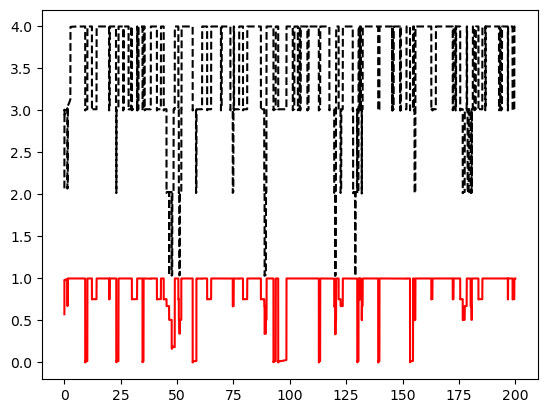

In [179]:
plt.plot(tlist, N0, color='red')
plt.plot(tlist, Ntot, color='black', linestyle='--')

In [180]:
from joblib import Parallel, delayed

Ntraj = 200
Ntimes = 1200
tlist = np.linspace(0, 100, Ntimes)  # in ns
options = Options(atol=1e-7, norm_t_tol=1e-7, norm_tol=1e-5)

# Define a function for the computation of a single trajectory
def compute_trajectory(ntraj):
    sol = mcsolve(Hin, psi0, tlist, c_jumps, [], ntraj=1, options=options)
    psi_t = sol.states
    psi_ss = psi_t[Ntimes - 1]
    rho_ss = psi_ss * psi_ss.dag()
    Sq = entropy_vn(rho_ss.ptrace(0))
    Ntot = np.abs(expect(opNtot, psi_ss))
    return Sq, Ntot

# Use joblib to parallelize the loop
results = Parallel(n_jobs=5)(
    delayed(compute_trajectory)(ntraj) for ntraj in range(Ntraj)
)

# Aggregate the results
arr_Sq, arr_Ntot = zip(*results)
arr_Sq = list(arr_Sq)
arr_Ntot = list(arr_Ntot)

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.38s
Total run time:   1.63s
Total run time:   1.64s
Total run time:   1.64s
Total run time:   1.76s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   1.40s
Total run time:   1.42s
Total run time:   1.89s
Total run time:   2.05s
Total run time:   2.04s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time:   0.00s. Est. time left: 00

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_1564/2920820602.py:26: UserWarning:

The figure layout has changed to tight



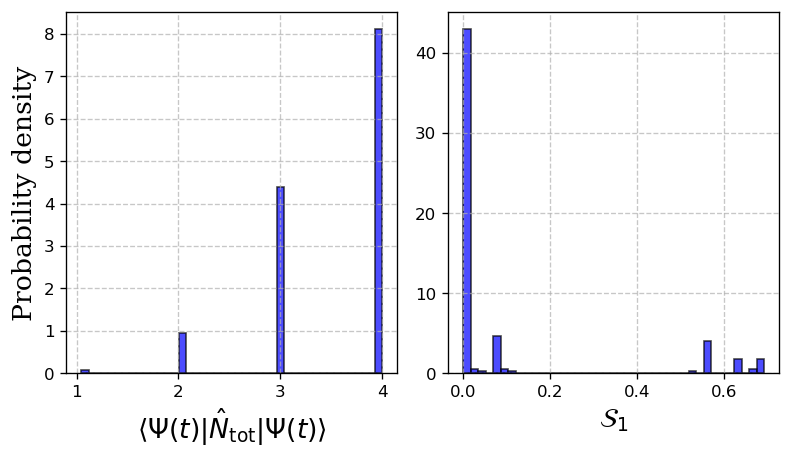

In [181]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Create the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=120, constrained_layout=True)

# Plot 2: Histogram of arr_c0exp (on the left)
axes[0].hist(arr_Ntot, bins=40, color='blue', edgecolor='black', alpha=0.7, density=True)
axes[0].set_xlabel(r'$\langle{\Psi(t)| \hat{N}_{\rm tot}| \Psi(t)\rangle}$', fontdict=font)
axes[0].set_ylabel('Probability density', fontdict=font)
#axes[0].set_xlim((0.4, 0.6))
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot 1: Histogram of arr_cexp (on the right)
axes[1].hist(arr_Sq, bins=40, color='blue', edgecolor='black', alpha=0.7, density=True)
axes[1].set_xlabel(r'$\mathcal{S}_1$', fontdict=font)
#axes[1].set_ylabel('Probability density', fontdict=font)
#axes[1].set_xlim((1, 1.5))
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.gcf().set_size_inches(170 / 25.4, 100 / 25.4)  # Convert mm to inches
plt.tight_layout()

#plt.savefig("zpl_AS_probability_density.pdf")

plt.show()